# Particle classification from deep inelastic electron-proton scattering

This project aims to find the bes model to classify subatomic particles that are products of a high energy collision between an electron and a proton, based on momentum, energy, mass,and other fetures obtained by a detector.

## Business understanding 
Particle identification is a fundamental task in high energy physics, where scientists study the properties and behavior of subatomic particles. Accurate particle identification is critical for a wide range of applications, including particle tracking, event reconstruction, and particle physics experiments.

One reason why AI is necessary for particle identification in high energy physics is that the datasets generated by particle detectors are typically very large and complex, with millions or billions of data points. These datasets often contain noise, background events, and multiple particle interactions, which can make it difficult for human experts to identify and classify particles accurately and efficiently.

AI techniques, such as machine learning and deep learning, are well-suited to handle large and complex datasets, and can automate the process of particle identification. For example, supervised learning algorithms can be trained on large datasets of labeled particles to learn the characteristics and properties of different particle types. Once trained, these algorithms can accurately and quickly classify new particles based on their features and properties.

Another advantage of using AI for particle identification is that it can help scientists discover new particles and phenomena that may be difficult to detect using traditional methods. For example, deep learning algorithms can be used to analyze patterns and anomalies in large datasets, and identify unusual or unexpected events that may indicate the presence of new particles or interactions.

Overall, AI is necessary for particle identification in high energy physics because it enables scientists to process and analyze large and complex datasets, automate the process of particle identification, and discover new particles and phenomena that may be difficult to detect using traditional methods.

## Data extraction 
As explained in the **README.md** file, first we need to download the dataset we will be using, from this link:
https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses

It is a dataset generatied by a simulation software called GEANT from the CERN laboratories. Mor information about the simulated detectors is found here> https://www.ge.infn.it/geant4/training/ptb_2009/detector_response.pdf

For future reference, other similar datasets can be found in these sources:
-     **HEPData**: This is a large collection of particle physics datasets, including datasets for particle identification. The datasets are curated by the HEPData project and are available for download in a variety of formats. 
    - HEPData: https://www.hepdata.net/
- **LHC Olympics 2020**: This is a competition organized by the ATLAS and CMS experiments at CERN, which provides a set of simulated particle physics data for participants to analyze and classify. The data is labeled with information about the type of particles and their properties.
    - LHC Olympics 2020: https://www.kaggle.com/c/lhcolympics2020/data
- **MINERvA experiment**: This is a dataset of neutrino interactions collected by the MINERvA experiment at Fermilab. The dataset includes labeled data for particle identification and has been used in several studies and competitions.
    - MINERvA experiment: https://minerva-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=14194
- **Kaggle particle identification challenge**: This is a competition organized by Kaggle, which provides a dataset of simulated particle physics events for participants to classify. The dataset is labeled with information about the type of particles and their properties.
   - Kaggle particle identification challenge: https://www.kaggle.com/c/flavours-of-physics/data

IMPORTANT 

Data files Files should be saved in the same place as this notebook inside the folder **Collision Dataset** with the name *collision_simulations.csv* (renamed the file from *pid-M5.csv*)

### Starting
to get started we need to download the required modules:

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from tensorflow.keras.utils import to_categorical
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Now, to access the data we simply read the csv from the folder. (This is where correct naming and storing of the downloaded file is important)

In [2]:
Collisions_df = pd.read_csv("./Collision Dataset/collision_simulations.csv") 

In [3]:
Collisions_df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [4]:
Collisions_df.shape

(5000000, 7)

In [5]:
Collisions_df.isna().sum()

id       0
p        0
theta    0
beta     0
nphe     0
ein      0
eout     0
dtype: int64

Our dataset containsa total of 5 million rows, **each row represents a particle** produced un a collision. Multiple particles can be originated in the same collision event. All events are a highly energtic collision between an electron and a proton. Data has no null values 

### About the features:
- **id**: Identification of the particle event, i.e., what is the product particle after the collision. This is our target variable. 
- **p**: Momentum of the particle when it reaches the detector (GeV/c)  
- **theta**: azimutal angle (radians)
- **beta**: polar angle (radians)
- **nphe**: number of photo electrons produced in the photomultipler
- **ein**: energy in 
- **eout**: energy out 

Produced particles 
- positron
- pion 
- kaon 
- Proton (it is possible that the original proton only absorbs the energy of the scattering electron and have a push as a result)

Now, to determine how many particles of each kind were registered, lets count them

In [6]:
 
Collisions_df.id = Collisions_df.id.map({-11: '0', 211: '1', 321: '2', 2212: '3'})
C = Collisions_df.copy().groupby("id")['id'].count()

In [7]:
q = ['positron','pion','kaon','proton']
print("Total number of events per particle\n")
for i,j in zip(q,list(C)):
    print(i,":>>>>",j)

Total number of events per particle

positron :>>>> 14847
pion :>>>> 2806833
kaon :>>>> 232471
proton :>>>> 1945849


## Data cleaning and exploration

For now, lets explore our columns, starting with a correlation map 

<AxesSubplot:>

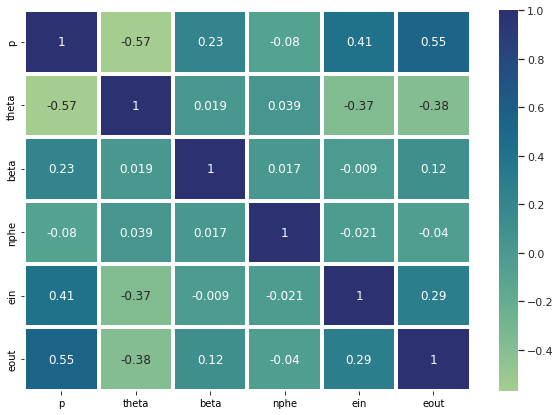

In [8]:
fig, ax = plt.subplots(figsize=(10,7))  
sns.set(font_scale=1)
sns.heatmap(Collisions_df.corr() , annot= True, linewidths=3, ax=ax, cmap="crest")


We noticed that the highest (negative) correlation happens between the momentum ($P$) and the scattering angle ($\theta$). However, it is not a strongcorrelation, hence, we can asume there is no linear dependencies between columns and we can keep them all

Also, as we noticed before at the end of the previos section, our dataset suffers of a severe class imbalance. The following pie chart will illustrate how is the distribution of events. 

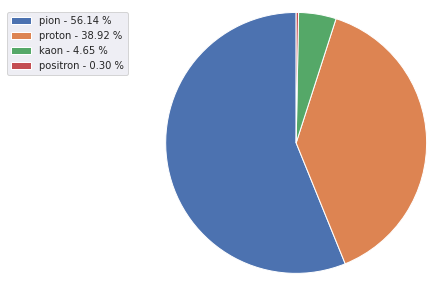

In [9]:
plt.figure(figsize=(5, 5))
x = np.char.array(['pion','proton','kaon','positron'])
y = np.array([2806833, 1945849, 232471, 14847]) 
percent = 100.*y/y.sum()
patches, texts = plt.pie(y, startangle=90, radius=1.2) #colors=colors
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                           key=lambda x: x[2],
                                           reverse=True))
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
            fontsize=10)

plt.savefig('piechart.png', bbox_inches='tight')

The **Positron** class is almost nothing compared to the rest of the classes, if we trained a model with the data as it is, it will be biased towards a higher accuracy in classifiying correctly the mayority classes. Our approach will then be to implement an undersampling technique and an oversampling technique to balance the classes.



### How to deal with the Imbalanced dataset
The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

We already saw how small the Positron class is. In order to balance it out, out fist modification will be to undersample the rest of the classes as following 

In [10]:
# For this model, we will first reduce the dataset so that pions protons and kaons have the same number of rows.
# 14847 rows of the dataset correspond to Positron events.

#undersampling randomly to 14847*2 events for Pions
df_pion = Collisions_df.loc[Collisions_df["id"] == '1'].sample(n = 14847*2, random_state = 1)
#undersampling randomly to 14847*2 events for Kaons
df_proton = Collisions_df.loc[Collisions_df["id"] == '2'].sample(n = 14847*2, random_state = 1)
#undersampling randomly to 14847*2 events for Protons
df_kaon = Collisions_df.loc[Collisions_df["id"] == '3'].sample(n = 14847*2, random_state = 1)

#Selecting only the 14847 Positron events
df_positron = Collisions_df.loc[Collisions_df["id"] == '0']

#Merging all selections
Collisions_df_2 = pd.concat([df_pion,df_proton,df_kaon,df_positron])
#shuffling the merged dataset 
Collisions_df_2 = Collisions_df_2.sample(frac=1) 

In [11]:
Collisions_df_2

,id,p,theta,beta,nphe,ein,eout
3320128,2,0.668498,0.197432,0.801589,0,0.044587,0.129274
2583695,3,0.693980,0.649964,0.588426,0,0.000000,0.000000
1692284,1,1.519490,0.267541,0.993705,0,0.016525,0.246647
4674950,3,1.145950,0.309701,0.778249,0,0.115038,0.000000
2423303,3,1.554890,0.328070,0.851640,0,0.039048,0.091737
...,...,...,...,...,...,...,...
1728799,1,2.439610,0.351779,1.000660,0,0.363287,0.163012
2740189,3,0.804303,0.415595,0.662947,0,0.084459,0.000000
1491310,3,0.824292,0.365865,0.660178,0,0.080156,0.036896
184441,3,1.614710,0.444437,0.872285,0,0.094987,0.082765


In [12]:
Collisions_df_2.groupby("id")['id'].count()

id
0    14847
1    29694
2    29694
3    29694
Name: id, dtype: int64

Now we have the mayority classes all with the same number of rows but with the double with respect to the minority class. We now need to over sample the minority. We chose the SMOTE method for this

**SMOTE**(Synthetic Minority Over-sampling Technique) is a machine learning method that addresses the problem of class imbalance in datasets. It creates synthetic examples of the minority class by interpolating between existing examples. The algorithm selects a minority class example, finds its k nearest neighbors, and generates new examples by interpolating between the original example and its k neighbors. The sampling rate controls the amount of interpolation.

This implementation will occur en the following section

## Features and Target 

Right before we implement the SMOTE method, we need to separate our target variable from the features and transform our target into a categorical variable

In [13]:
from tensorflow.keras.utils import to_categorical

X = Collisions_df_2.drop(['id'], axis=1) 
y = Collisions_df_2['id'] 
y = to_categorical(y)

A slight modification of SMOTE is **SMOTE-Tomek Links**. SMOTE-Tomek Links is a data preprocessing technique used in machine learning to improve classification performance on imbalanced datasets. The method combines two techniques: SMOTE (Synthetic Minority Over-sampling Technique) and Tomek Links. SMOTE is used to oversample the minority class by creating synthetic examples, while Tomek Links is used to remove overlapping examples from different classes that might be misclassified.

The algorithm first applies Tomek Links to remove overlapping instances, then applies SMOTE to oversample the minority class. The final dataset is then used to train a classifier. This approach can improve classification performance, especially on highly imbalanced datasets where the minority class is severely underrepresented. SMOTE-Tomek Links is a powerful method that can be used in combination with other techniques such as undersampling or cost-sensitive learning to further improve classification performance on imbalanced datasets.

In [14]:
## We will now implement a SMOTE - Tomek Links algorithm
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X, y = resample.fit_resample(X, y)


/home/jigalindo0104/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Now, let's see how is the distribution of our balanced dataset 

In [15]:
## we will rejoin the dataset to create a pairplot 
def d(x):
    dd = {0: 'positron', 1: 'pion', 2: 'kaon', 3: 'proton'}
    return dd[x]

y_df= pd.Series(np.array(list(map(d,np.argmax(y, axis=1)))))

DF =X.reset_index().drop('index',axis=1).copy()

DF["particle"] = y_df.reset_index().drop('index',axis=1)

In [16]:
#X.reset_index().drop('index',axis=1)
DF

,p,theta,beta,nphe,ein,eout,particle
0,0.668498,0.197432,0.801589,0,0.044587,0.129274,kaon
1,0.693980,0.649964,0.588426,0,0.000000,0.000000,proton
2,1.519490,0.267541,0.993705,0,0.016525,0.246647,pion
3,1.145950,0.309701,0.778249,0,0.115038,0.000000,proton
4,1.554890,0.328070,0.851640,0,0.039048,0.091737,proton
...,...,...,...,...,...,...,...
118267,1.761501,0.246114,1.014896,92,0.312461,0.140822,positron
118268,0.448918,0.227560,1.003314,0,0.000000,0.000000,positron
118269,0.318904,0.246346,0.993009,0,0.000000,0.000000,positron
118270,0.912690,0.288988,0.981355,105,0.139734,0.031411,positron


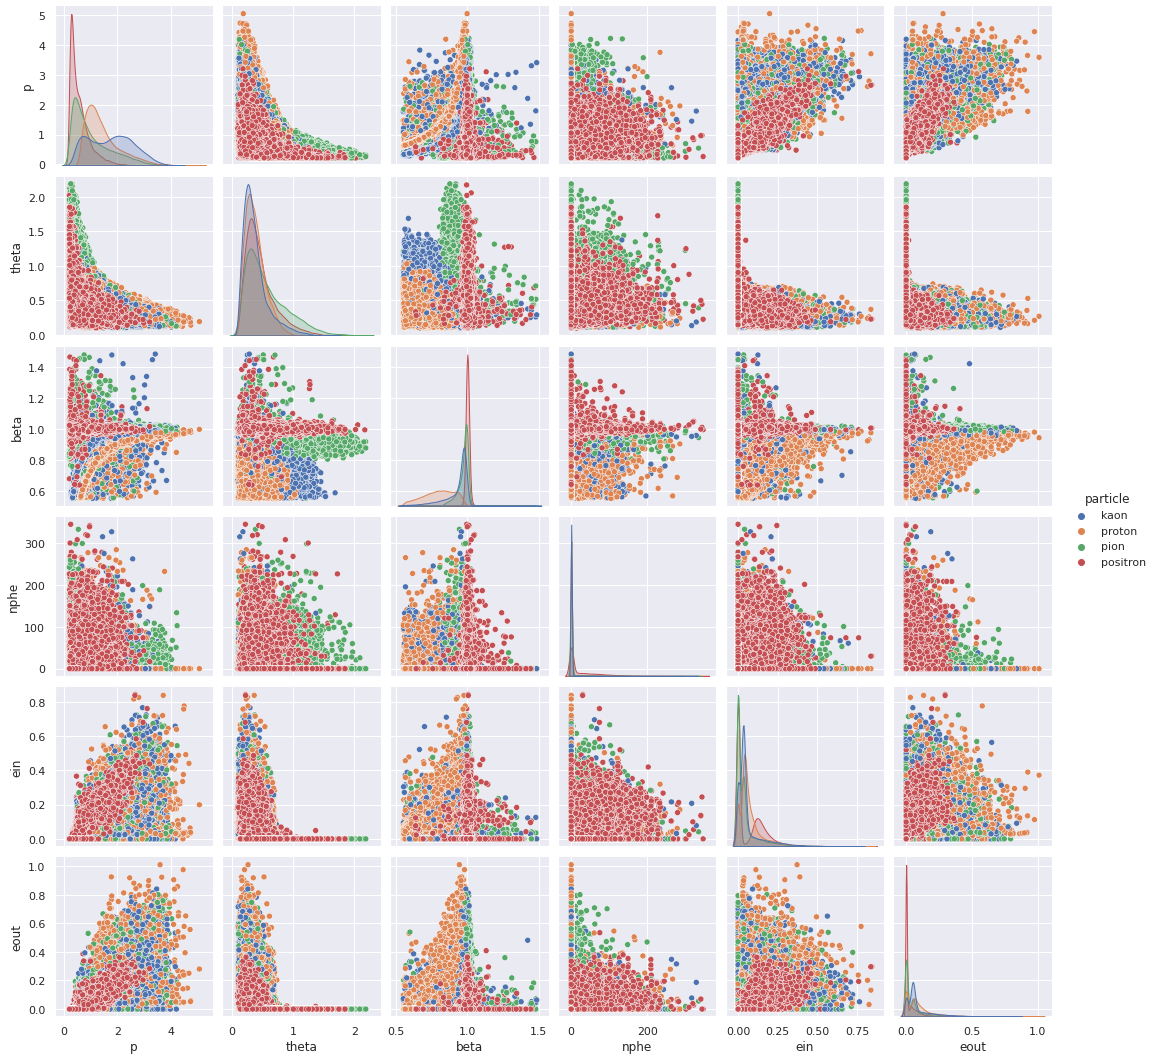

In [17]:
sns.pairplot(DF, hue="particle")

As we see above, data is now more evenly distributed. It is also clearer that in the dimension of $\beta$ against almost every other feature, groups are segregated and can be differentiable easier than in other dimensions.

Now, for building our model, we will split into train and test sets, leaving 20% of the data for test.

In [18]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.20)

In [19]:
#Is is now important to scale every feture to have them all even 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Neural Network

Now that the data is clean and balanced it is time to build our neural network. TO keep it simple we will only add 1 inner layer. To find the optimal number of neurons, we will do a grid search.

For the input and inner layer, we chose the **relu** activation function, while fot the output layer we chose a **sigmoid** function.

- input layer: 6 neurons (6 features)
- dense layer: # of neurons to be determined
- output layer: 4 neurons (4 classes)

In [20]:
## We define the model running function 

def ParticleNN(n):
    # Define your neural network architecture
    model = Sequential()
    model.add(Dense(n, input_dim=6, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))

    # Compile model with a loss function and optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train model on training data with 
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # Evaluate model on testing data
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))
    return model, accuracy 

In [21]:
nn = [4,6,8,10]
models = []
for n in nn:
    print('Model with '+str(n)+' neurons in the dense layer >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    models.append(ParticleNN(n))
    
print(models)

Model with 6 neurons in the dense layer >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/100
2957/2957 [==============================] - 3s 556us/step - loss: 0.3373 - accuracy: 0.7222
Epoch 2/100
2957/2957 [==============================] - 2s 522us/step - loss: 0.2126 - accuracy: 0.8744
Epoch 3/100
2957/2957 [==============================] - 2s 528us/step - loss: 0.1840 - accuracy: 0.9011
Epoch 4/100
2957/2957 [==============================] - 2s 512us/step - loss: 0.1691 - accuracy: 0.9095
Epoch 5/100
2957/2957 [==============================] - 2s 538us/step - loss: 0.1602 - accuracy: 0.9146
Epoch 6/100
2957/2957 [==============================] - 2s 537us/step - loss: 0.1546 - accuracy: 0.9187
Epoch 7/100
2957/2957 [==============================] - 2s 549us/step - loss: 0.1505 - accuracy: 0.9219
Epoch 8/100
2957/2957 [==============================] - 2s 519us/step - loss: 0.1479 - accuracy: 0.9240
Epoch 9/100
2957/2957 [==============================] - 2s 545us/step - loss: 0.1460

2957/2957 [==============================] - 2s 555us/step - loss: 0.1203 - accuracy: 0.9304
Epoch 78/100
2957/2957 [==============================] - 2s 545us/step - loss: 0.1203 - accuracy: 0.9308
Epoch 79/100
2957/2957 [==============================] - 2s 517us/step - loss: 0.1202 - accuracy: 0.9307
Epoch 80/100
2957/2957 [==============================] - 2s 550us/step - loss: 0.1202 - accuracy: 0.9305
Epoch 81/100
2957/2957 [==============================] - 2s 578us/step - loss: 0.1202 - accuracy: 0.9306
Epoch 82/100
2957/2957 [==============================] - 2s 559us/step - loss: 0.1201 - accuracy: 0.9305
Epoch 83/100
2957/2957 [==============================] - 2s 570us/step - loss: 0.1203 - accuracy: 0.9308
Epoch 84/100
2957/2957 [==============================] - 2s 552us/step - loss: 0.1202 - accuracy: 0.9306
Epoch 85/100
2957/2957 [==============================] - 2s 556us/step - loss: 0.1202 - accuracy: 0.93040s - loss: 0.1192 - accura
Epoch 86/100
2957/2957 [=========

2957/2957 [==============================] - 2s 540us/step - loss: 0.1045 - accuracy: 0.9353
Epoch 53/100
2957/2957 [==============================] - 2s 509us/step - loss: 0.1044 - accuracy: 0.9355
Epoch 54/100
2957/2957 [==============================] - 2s 533us/step - loss: 0.1044 - accuracy: 0.9354
Epoch 55/100
2957/2957 [==============================] - 2s 528us/step - loss: 0.1044 - accuracy: 0.9354
Epoch 56/100
2957/2957 [==============================] - 2s 555us/step - loss: 0.1043 - accuracy: 0.9352
Epoch 57/100
2957/2957 [==============================] - 2s 561us/step - loss: 0.1043 - accuracy: 0.9358
Epoch 58/100
2957/2957 [==============================] - 2s 560us/step - loss: 0.1043 - accuracy: 0.9353
Epoch 59/100
2957/2957 [==============================] - 2s 553us/step - loss: 0.1042 - accuracy: 0.9354
Epoch 60/100
2957/2957 [==============================] - 2s 548us/step - loss: 0.1043 - accuracy: 0.9349
Epoch 61/100
2957/2957 [==============================] - 2

2957/2957 [==============================] - 2s 555us/step - loss: 0.1229 - accuracy: 0.9353
Epoch 28/100
2957/2957 [==============================] - 2s 574us/step - loss: 0.1227 - accuracy: 0.9357
Epoch 29/100
2957/2957 [==============================] - 2s 552us/step - loss: 0.1223 - accuracy: 0.9359
Epoch 30/100
2957/2957 [==============================] - 2s 562us/step - loss: 0.1221 - accuracy: 0.9355
Epoch 31/100
2957/2957 [==============================] - 2s 546us/step - loss: 0.1219 - accuracy: 0.9358
Epoch 32/100
2957/2957 [==============================] - 2s 535us/step - loss: 0.1217 - accuracy: 0.9356
Epoch 33/100
2957/2957 [==============================] - 2s 541us/step - loss: 0.1215 - accuracy: 0.9353
Epoch 34/100
2957/2957 [==============================] - 2s 542us/step - loss: 0.1211 - accuracy: 0.9353
Epoch 35/100
2957/2957 [==============================] - 2s 544us/step - loss: 0.1211 - accuracy: 0.93560s - loss: 0.121
Epoch 36/100
2957/2957 [===================

2957/2957 [==============================] - 2s 604us/step - loss: 0.3189 - accuracy: 0.7407
Epoch 2/100
2957/2957 [==============================] - 2s 591us/step - loss: 0.1849 - accuracy: 0.9001
Epoch 3/100
2957/2957 [==============================] - 2s 591us/step - loss: 0.1577 - accuracy: 0.9179
Epoch 4/100
2957/2957 [==============================] - 2s 628us/step - loss: 0.1451 - accuracy: 0.9263
Epoch 5/100
2957/2957 [==============================] - 2s 611us/step - loss: 0.1371 - accuracy: 0.9312
Epoch 6/100
2957/2957 [==============================] - 2s 590us/step - loss: 0.1316 - accuracy: 0.9334
Epoch 7/100
2957/2957 [==============================] - 2s 605us/step - loss: 0.1275 - accuracy: 0.9356
Epoch 8/100
2957/2957 [==============================] - 2s 618us/step - loss: 0.1246 - accuracy: 0.9362
Epoch 9/100
2957/2957 [==============================] - 2s 614us/step - loss: 0.1224 - accuracy: 0.9368
Epoch 10/100
2957/2957 [==============================] - 2s 593us/

2957/2957 [==============================] - 2s 548us/step - loss: 0.0961 - accuracy: 0.9397
Epoch 79/100
2957/2957 [==============================] - 2s 544us/step - loss: 0.0959 - accuracy: 0.9398
Epoch 80/100
2957/2957 [==============================] - 2s 589us/step - loss: 0.0958 - accuracy: 0.9396
Epoch 81/100
2957/2957 [==============================] - 2s 568us/step - loss: 0.0956 - accuracy: 0.9396
Epoch 82/100
2957/2957 [==============================] - 2s 538us/step - loss: 0.0954 - accuracy: 0.9396
Epoch 83/100
2957/2957 [==============================] - 2s 587us/step - loss: 0.0953 - accuracy: 0.9388
Epoch 84/100
2957/2957 [==============================] - 2s 591us/step - loss: 0.0950 - accuracy: 0.9396
Epoch 85/100
2957/2957 [==============================] - 2s 580us/step - loss: 0.0948 - accuracy: 0.9395
Epoch 86/100
2957/2957 [==============================] - 2s 607us/step - loss: 0.0946 - accuracy: 0.9396
Epoch 87/100
2957/2957 [==============================] - 2

In [30]:
### Selecting the one with highest accuracy

mx = (0,0)
for m in models:
    if mx[1] <= m[1]:
        mx = m
    else: 
        continue
mx

(<keras.engine.sequential.Sequential at 0x7f7e101b3df0>, 0.9427605271339417)

### Model Evaluation 

We will analze te performance of the model usign a confusion matrix

In [31]:
model = mx[0] 

from sklearn.metrics import confusion_matrix

y_prediction = model.predict(X_test)
y_prediction = np.array(list(map(d,np.argmax (y_prediction, axis = 1))))
print(y_prediction)
y_test_copy = y_test.copy()
y_test_copy= np.array(list(map(d,np.argmax(y_test_copy, axis=1))))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test_copy, y_prediction )#, normalize='pred')
print(result)

['kaon' 'proton' 'proton' ... 'kaon' 'kaon' 'proton']
[[5562  200   13  176]
 [ 350 5230  241   58]
 [  14  208 5673    4]
 [  88    2    0 5836]]


Also, we can calculate the total number of predictions per class

In [35]:
count = {"proton":0,"kaon":0,"positron":0,"pion":0}
for a in list(y_prediction):
    count[a]+= 1
count    

{'proton': 6074, 'kaon': 6014, 'positron': 5927, 'pion': 5640}

And, the total number of actual particles per class

In [33]:
count = {"proton":0,"kaon":0,"positron":0,"pion":0}
for a in list(y_test_copy):
    count[a]+= 1
count

{'proton': 5926, 'kaon': 5951, 'positron': 5899, 'pion': 5879}

To have a better perspective of the confusion matrix let's print it with the help of seaborn 

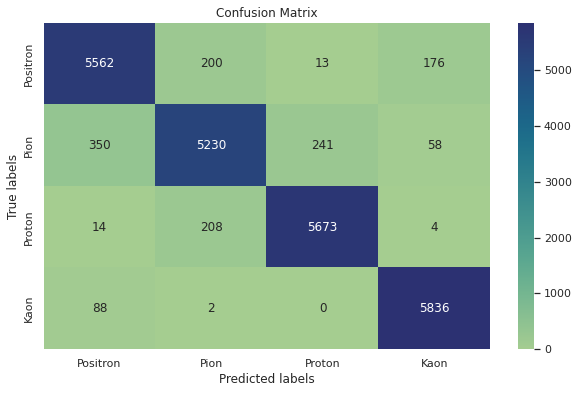

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt     

fig,ax= plt.subplots(figsize=(10, 6))
sns.heatmap(result, annot=True, fmt='g', ax=ax ,cmap="crest");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positron','Pion', 'Proton','Kaon']); ax.yaxis.set_ticklabels(['Positron','Pion', 'Proton','Kaon']);

   - The first row represents the "Proton" class. The model correctly classified 5562 instances as Protons, misclassified 200 as Kaons, 13 as Pions, and 176 as Positrons.
   - The second row represents the "Kaon" class. The model correctly classified 5230 instances as Kaons, misclassified 350 as Protons, 241 as Pions, and 58 as Positrons.
   - The third row represents the "Pion" class. The model correctly classified 5673 instances as Pions, misclassified 14 as Protons, 208 as Kaons, and 4 as Positrons.
   - The fourth row represents the "Positron" class. The model correctly classified 5836 instances as Positrons, misclassified 88 as Protons, and 2 as Kaons.
    
As a first observation, one can notice that it is indeed an accurate model. Most predictions lie inside the diagonal of the confusion matrix, this means that most predictions are done correcly, but there is still some points with the wrong label. To further understand the behaiviour, we can calculate some more metrics 

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test_copy, y_prediction, target_names=['positron','pion','proton','kaon']))

              precision    recall  f1-score   support

    positron       0.92      0.93      0.93      5951
        pion       0.93      0.89      0.91      5879
      proton       0.96      0.96      0.96      5899
        kaon       0.96      0.98      0.97      5926

    accuracy                           0.94     23655
   macro avg       0.94      0.94      0.94     23655
weighted avg       0.94      0.94      0.94     23655



As shown above, the model has an overall accuracy of $94\%$, The Kaon class is the one that is performing best, followed by the Proton. The Pion class comes out with the lowest recall but still high(89%)    

#### Conslusion 
Compared to the fisrt naive model, the performance of the model trained with the balanced dataset and tuned for the dense layer neurons has a significant increase in the overall accuracy and a really good performance in the rest of the metrics. This model exhibits potencial to be implemented as a tool for helping scientists with the classification of particles in an accurate and efficient way. Not only in the problem of an electron-proton scattering, bbut also in anay other particle physics task. 

The ability to precisely classify particles can revolutionize particle physics research, potentially leading to the discovery of new particles and phenomena. It can also have practical applications in fields such as medical imaging, where accurate particle classification is essential for diagnosis and treatment.

Overall, the development of this technology can have a profound impact on our understanding of the fundamental building blocks of the universe and can lead to advances in a wide range of fields.
